In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(r'../')
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
import string
import nltk
from nltk.corpus import stopwords

# Data Load

In [2]:
os.getcwd()

'E:\\kaggle\\NLP-with-diasaster-Tweets-master'

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sub_sample = pd.read_csv("./data/sample_submission.csv")

print(train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


In [4]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


keyword와 location에 NULL 값 존재 확인

## Exploring the Target Column

train 값에 중복되는 행이 있는지 확인

In [8]:
train.duplicated().sum()
train = train.drop_duplicates().reset_index(drop=True)

## Class Unbalance Check

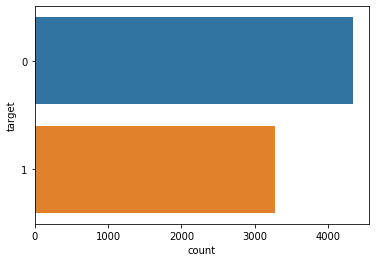

In [9]:
# Visualization 1
# Class Balance
train['target'].value_counts(normalize=True)
sns.countplot(y=train.target);

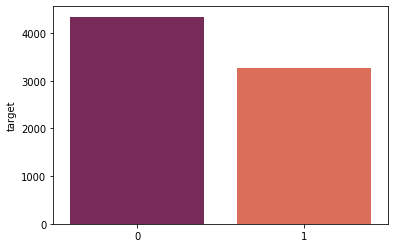

In [10]:
# visualization 2
sns.barplot(train['target'].value_counts().index, train['target'].value_counts(), palette='rocket')

In [11]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
train.groupby('keyword').count()

,id,location,text,target
keyword,,,,
ablaze,36,29,36,36
accident,35,28,35,35
aftershock,34,25,34,34
airplane%20accident,35,29,35,35
ambulance,38,26,38,38
...,...,...,...,...
wounded,37,27,37,37
wounds,33,27,33,33
wreck,37,27,37,37


keyword 변수는 cateogrical임을 확인

In [13]:
train.groupby('location').count()

,id,keyword,text,target
location,,,,
,1,1,1,1
Glasgow,1,1,1,1
"Melbourne, Australia",1,1,1,1
News,1,1,1,1
å_,1,1,1,1
...,...,...,...,...
å_: ?? ÌÑ ? : ?,1,1,1,1
å_å_Los Mina Cityã¢,1,1,1,1
å¡å¡Midwest Û¢Û¢,1,1,1,1


이상한 문자 확인 -> 전처리를 통해 제거해줘야 한다

## keywords

In [14]:
#Check number of unique keywords, and whether they are the same for train and test sets
print(train.keyword.nunique(), test.keyword.nunique())

221 221


keyword 변수는 결측치를 제외하고 총 221개의 label이 존재하는 것을 알 수 있음.   
- unique()를 사용하면 category 명을 출력

In [15]:
train.keyword.value_counts().iloc[:15].index

Index(['fatalities', 'deluge', 'armageddon', 'harm', 'damage', 'body%20bags',
       'sinking', 'evacuate', 'twister', 'collided', 'fear', 'siren',
       'windstorm', 'outbreak', 'whirlwind'],
      dtype='object')

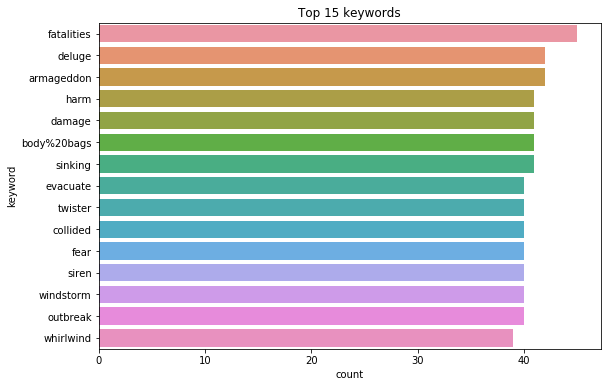

In [16]:
# Most common Keywords
plt.figure(figsize = (9,6))
sns.countplot(y=train.keyword, order=train.keyword.value_counts().iloc[:15].index)
plt.title("Top 15 keywords")
plt.show()

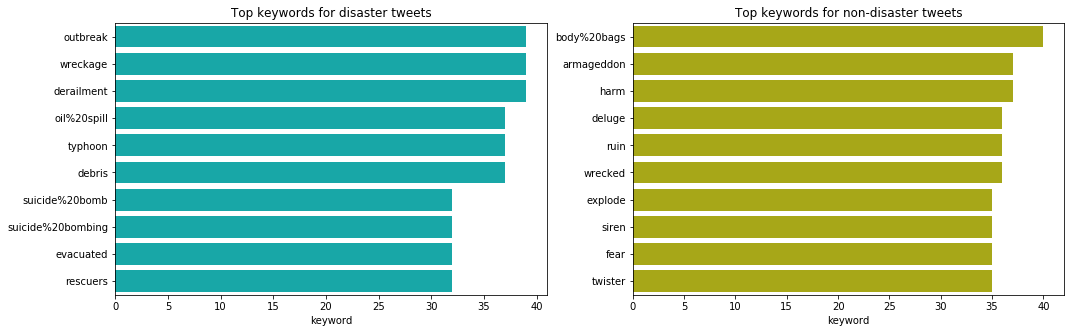

In [17]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(17,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

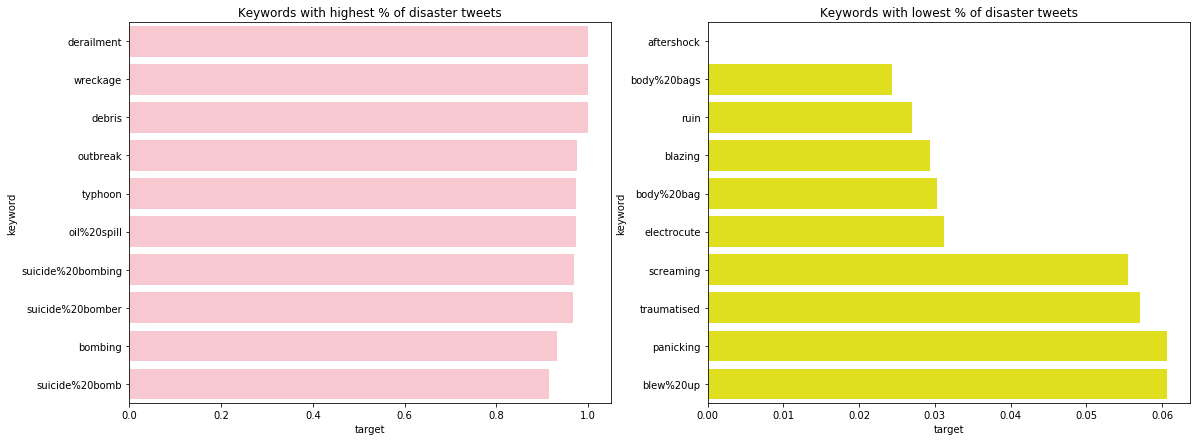

In [18]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(19,7))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## Location

In [19]:
print(train.location.nunique(), test.location.nunique())

3341 1602


In [20]:
train.location.value_counts().iloc[:15].index

Index(['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria', 'UK',
       'Los Angeles, CA', 'India', 'Mumbai', 'Washington, DC', 'Kenya',
       'Worldwide', 'Australia', 'Chicago, IL'],
      dtype='object')

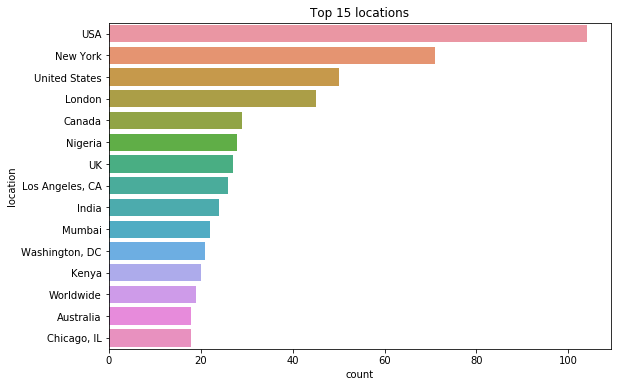

In [21]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order=train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

같은 나라임에도 불구하고 USA와 United States를 전혀 다른 도시로 보고 있음.   
-> 전처리를 통해 같게 해줘야 함

In [22]:
train.location.value_counts()

USA                   104
New York               71
United States          50
London                 45
Canada                 29
                     ... 
WORLDWIDE-BOSTON        1
Vancouver, BC.          1
ELVY                    1
[ Blonde Bi Fry. ]      1
St PetersburgFL         1
Name: location, Length: 3341, dtype: int64

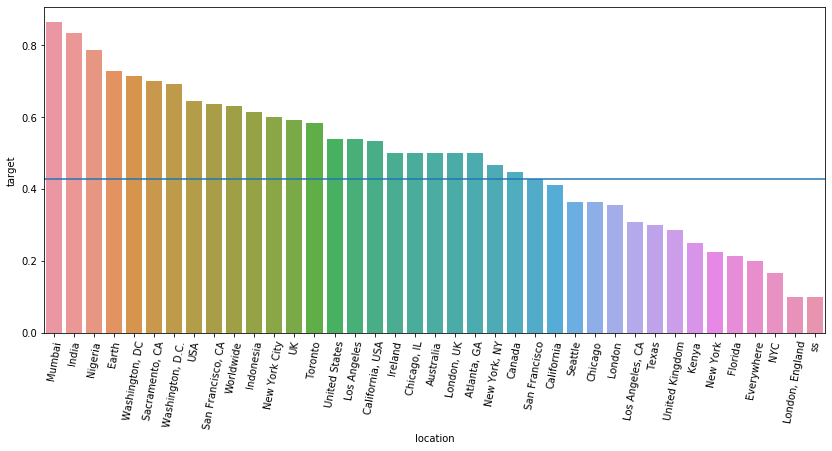

In [23]:
# location의 label 갯수를 큰 값부터 나열
raw_loc = train.location.value_counts()
# list로 만든다.
top_loc = list(raw_loc[raw_loc>=10].index)
# isin 구문은 해당된 열이 list의 값들을 포함하고 있는 모든 행들을 골라낼 때 주로 쓰인다. 
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)

# target의 평균값을 수평선으로 추가 
plt.axhline(np.mean(train.target))

# xticks : x축에 있는 label의 글씨를 rotation(각)을 통해 어떻게 표시할 지 
plt.xticks(rotation=80)
plt.show()

In [34]:
train[train.location.isin(top_loc)]

,id,keyword,location,text,target,location_clean,text_clean,hashtags,mentions,links,text_len,word_count,stop_word_count,punctuation_count,hashtag_count,mention_count,link_count,caps_count,caps_ratio
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,London,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,no,no,http://t.co/qqsmshaJ3N,53,12,5,0,1,1,1,33,0.622642
51,74,ablaze,India,Man wife get six years jail for setting ablaze...,1,India,Man wife get six years jail for setting ablaze...,no,no,http://t.co/eV1ahOUCZA,52,10,2,0,1,1,1,1,0.019231
55,79,ablaze,USA,#Kurds trampling on Turkmen flag later set it ...,1,USA,#Kurds trampling on Turkmen flag later set it ...,Kurds Diyala,no,http://t.co/4IzFdYC3cg,112,18,5,2,2,1,1,5,0.044643
66,95,ablaze,San Francisco,@ablaze what time does your talk go until? I d...,0,San Francisco,@ablaze what time does your talk go until? I d...,no,ablaze,no,85,19,10,4,1,1,1,2,0.023529
70,100,accident,UK,http://t.co/GKYe6gjTk5 Had a #personalinjury a...,0,UK,Had a #personalinjury accident this summer? Re...,personalinjury solicitor OtleyHour,no,http://t.co/GKYe6gjTk5,106,17,7,6,3,1,1,4,0.037736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7540,10780,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,no,no,http://t.co/nn6Y0fD3l0,113,16,7,7,1,1,1,10,0.088496
7543,10784,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,no,no,http://t.co/5EBpYbFH4D,113,16,7,7,1,1,1,10,0.088496
7547,10788,wrecked,United States,I wonder how times someone has wrecked trying ...,0,USA,I wonder how times someone has wrecked trying ...,no,no,no,100,20,8,2,1,1,1,3,0.030000
7566,10815,wrecked,United States,http://t.co/qVx0VQTPz0 Cramer: Iger's 3 words ...,0,USA,Cramer: Iger's 3 words that wrecked Disney's s...,no,no,http://t.co/qVx0VQTPz0 http://t.co/vuWBSrSnrY,50,8,1,3,1,1,2,3,0.060000


The top 3 locations with highest % of disaster tweets are **Mumbai, Inida, and Nigeria**.  
As the location data is not clean, we see some interesting cases,  
such as **'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average.**  
  
We try to clean up the location and see if there is any difference:

Q. ss는 뭐임? South sudan?

## Data Processing Part

In [41]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'Mumbai' : 'India',
                           'Washington' : 'USA',
                           'Sacramento' : 'USA',
                           'Washington, D.C' : 'USA',
                           'San Francisco, CA' : 'USA',
                           'New York City' : 'USA',
                           'New York' : 'USA',
                           'NYC' : 'USA',
                           'United States' : 'USA',
                           'Los Angeles' : 'USA',
                           'Los Angeles, CA' : 'USA',
                           'California, USA' : 'USA',
                           'Atlanta, GA' : 'USA',
                           'New York, NY' : 'USA',
                           'Sanfrancisco' : 'USA',
                           'California' : 'USA',
                           'Seattle' : 'USA', 
                           'Texas' : 'USA',
                           'Florida' : 'USA',
                           'Chicago' : 'USA',
                           'Toronto' : 'Canada',
                           'United Kingdom' : 'UK',
                           'London' : 'UK',
                           'London, England' : 'UK',
                           'Earth' : 'World',
                           'Worldwide' : 'World',
                           'Everywhere' : 'World'
                           }, inplace=True)
test['location'].replace({'Mumbai' : 'India',
                           'Washington' : 'USA',
                           'Sacramento' : 'USA',
                           'Washington, D.C' : 'USA',
                           'San Francisco, CA' : 'USA',
                           'New York City' : 'USA',
                           'New York' : 'USA',
                           'NYC' : 'USA',
                           'United States' : 'USA',
                           'Los Angeles' : 'USA',
                           'Los Angeles, CA' : 'USA',
                           'California, USA' : 'USA',
                           'Atlanta, GA' : 'USA',
                           'New York, NY' : 'USA',
                           'Sanfrancisco' : 'USA',
                           'California' : 'USA',
                           'Seattle' : 'USA', 
                           'Texas' : 'USA',
                           'Florida' : 'USA',
                           'Chicago' : 'USA',
                           'Toronto' : 'Canada',
                           'United Kingdom' : 'UK',
                           'London' : 'UK',
                           'London, England' : 'UK',
                           'Earth' : 'World',
                           'Worldwide' : 'World',
                           'Everywhere' : 'World'
                           }, inplace=True)

In [42]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

KeyError: 'location_clean'

In [24]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

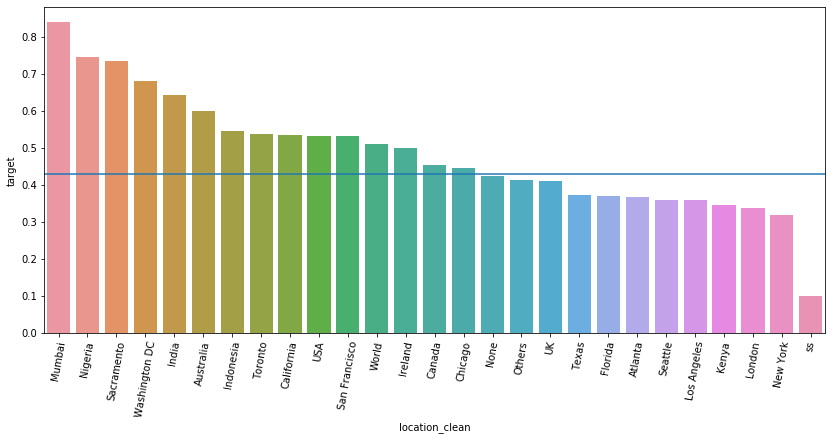

In [25]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

Mumbai and Nigeria are still on the top. Other than the strange 'ss', London and New York made the bottom of % of disaster tweets.

## Cleaning the Data

### Clean up Text Column

Here we clean up the text column by:
    - Making a 'clean' text column, removing links and unnecessary white spaces.
    - Creating separate columns containing lists of hashtags, mentions, and links.

In [28]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [29]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

## Create statistics from texts

In [31]:
!pip install wordcloud

In [32]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 19) (3263, 18)


In [33]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

## Most frequent words and bigrams

What are the most common unigrams (single word) and bigrams (two-word sequence)?

In [35]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)
# more_stopwords = {'https', 'amp'}
# stopwords = stopwords.union(more_stopwords)

### WordCloud

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
wc = WordCloud().generate(stopwords)
 
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object

In [38]:
!pip install nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kbh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

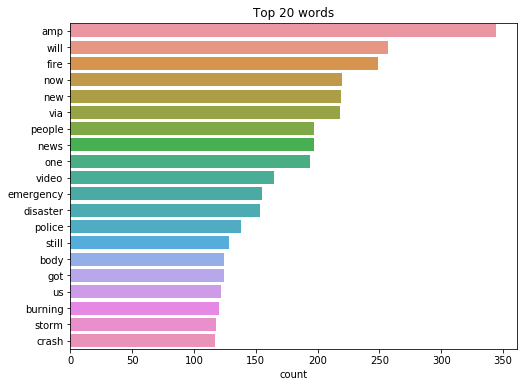

In [39]:
# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

We try to distinguish disaster and non-disaster tweets:

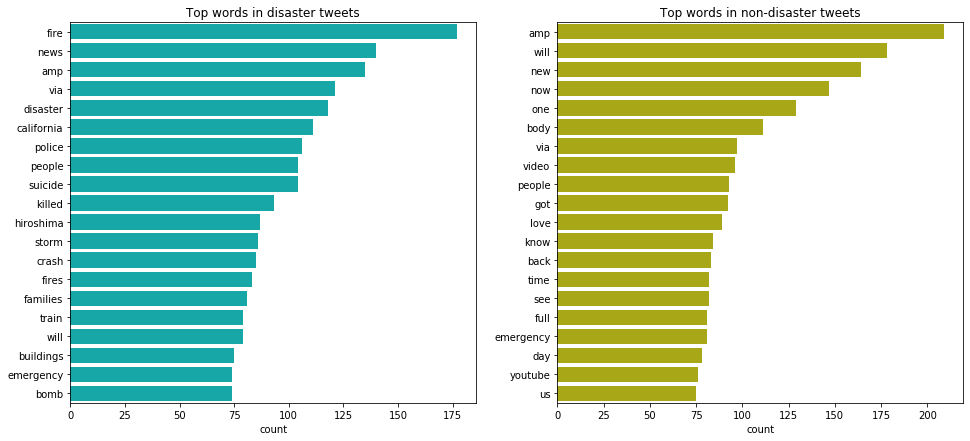

In [40]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

Findings:   
- Top two words in disaster tweets: 'fire' and 'news', don't make the top 20 on unreal disaster tweets.
- Words are more specific for real disaster tweets (e.g. 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb').

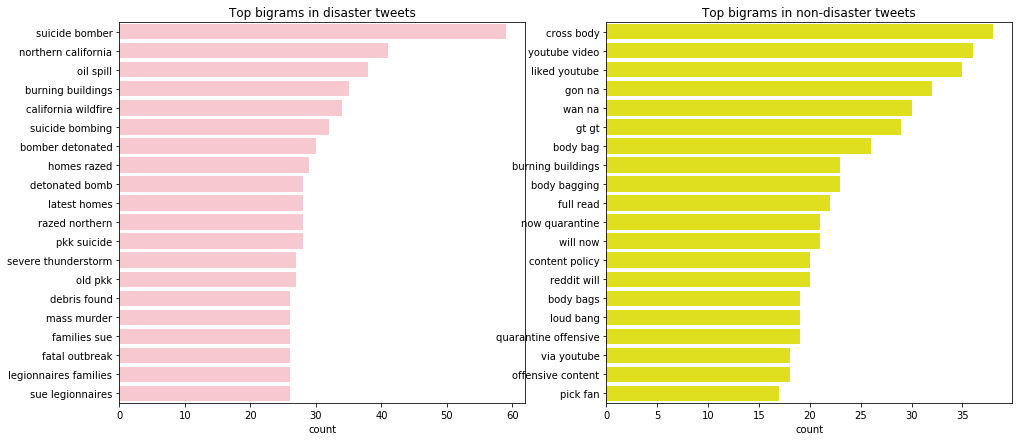

In [42]:
# Bigrams

from nltk import bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

Findings:  
- Most top bigrams in disaster tweets show certain kinds of catestrophe (e.g. suicide bomber, oil spill, california wildfire); for non-disaster tweets, only 'burning buildings' as top bigram look like a disaster;
- Top bigrams in disaster tweets have a more casual tone;
- 'youtube' appears in three of the twenty bigrams for non-disaster tweets; none in disaster tweets

## Feature Engineering

### Encoding and Vectorizers

As part of feature generation, we will:
- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [44]:
!pip install category_encoders

In [45]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


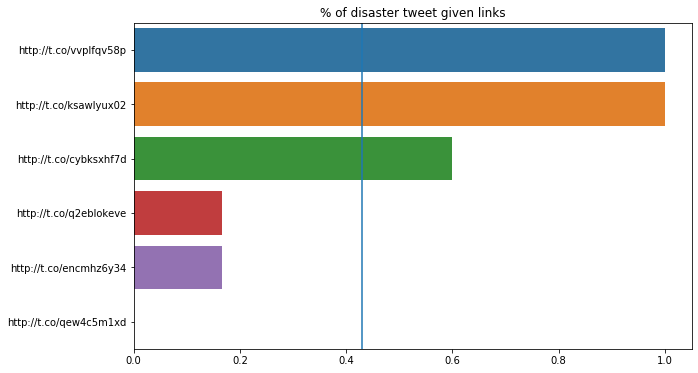

In [47]:
_ = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=_, y=_.index)
plt.axvline(np.mean(train.target))
plt.title('% of disaster tweet given links')
plt.show()

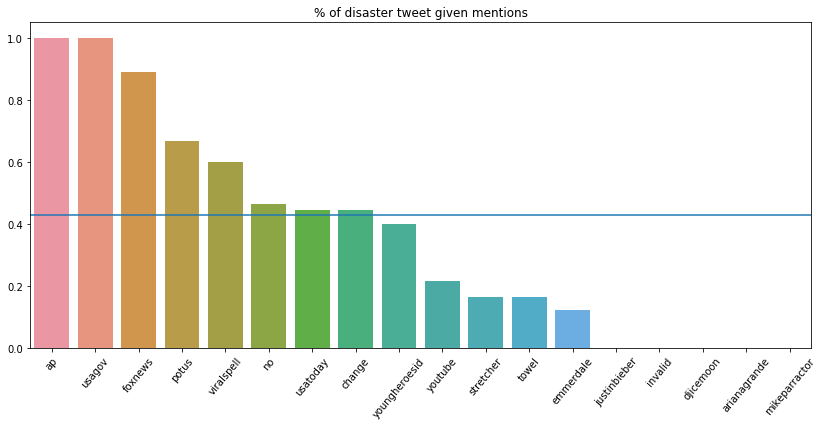

In [48]:
_ = (X_train_men.transpose().dot(train['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=_.index, y=_)
plt.axhline(np.mean(train.target))
plt.title('% of disaster tweet given mentions')
plt.xticks(rotation = 50)
plt.show()

In [49]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 100% of Tweets are disasters: 
['yyc', 'japan', 'science', 'rohingya', 'okwx', 'newyork', 'myanmar', 'mumbai', 'wx', 'libya', 'india', 'socialnews', 'hiroshima', 'hailstorm', 'earthquake', 'disaster', 'breaking', 'bestnaijamade', 'antioch', 'africa', 'sittwe', 'mh370', 'abstorm', 'worldnews', 'wildfire', 'wildfires']
Total: 26
Hashtags with which 0% of Tweets are disasters: 
['np', 'summerfate', 'job', 'jobs', 'animalrescue', 'kindle', 'fashion', 'bb17', 'dnb', 'ices', 'beyhive', 'edm', 'technology', 'dubstep', 'trapmusic', 'military', 'dance', 'soundcloud']
Total: 18


### TD-IDF Count

In [50]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [51]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1843) (3263, 1842)


## Regression Technique

### Logistic Regression

We try the simplest model with logistic regression, based on all features we created above. Before we fit a model, we first transform the features into the same scale with minimum 0 and maximum 1. We do this in the form of pipeline.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [53]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.8539


### F1 SCORE

In [54]:
# F-1 score
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f-1 score: 0.8195


### Confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,3976,366
1,746,2525


## Hypertuning

### Evaluate and Improve Our Model
Several things will be done:   
- Cross validation with shuffle split
- Feature selections
- Grid search for hyperparameters
- Identify errors  
Reference: scoring parameters

In [56]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.753


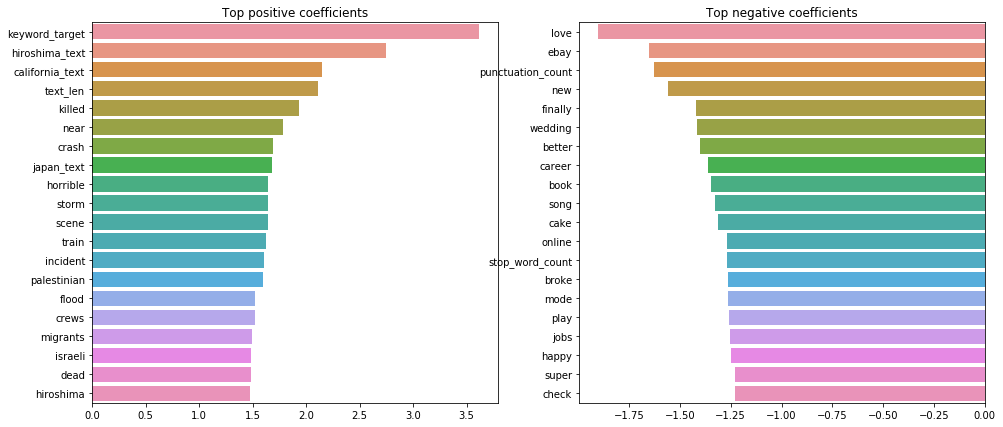

In [57]:
# Top features
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

Findings:  
- 'keyword_target' is the top positive coefficient, meaning the keyword column made a good feature
- hiroshima both as text and hashtag made the top 20 positive coefficients
- Punctuation count and stop word count are among top 20 negative coefficients
- None of the bigrams made the top features

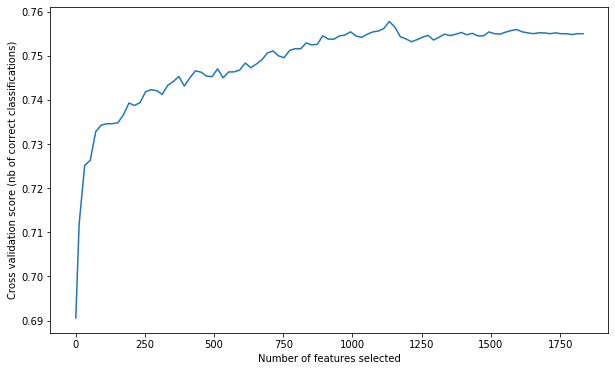

In [58]:
# Feature selection
from sklearn.feature_selection import RFECV

steps = 20
n_features = len(X_train.columns)
X_range = np.arange(n_features - (int(n_features/steps)) * steps, n_features+1, steps)

rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')

pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.insert(X_range, 0, 1), rfecv.grid_scores_)
plt.show()

In [59]:
print ('Optimal no. of features: %d' % np.insert(X_range, 0, 1)[np.argmax(rfecv.grid_scores_)])

Optimal no. of features: 1133


In [60]:
selected_features = X_train.columns[rfecv.ranking_ == 1]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

In [61]:
# lr2 = LogisticRegression(solver='liblinear', random_state=37)
pipeline.fit(X_train2, y_train)
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=456)
cv_score2 = cross_val_score(pipeline, X_train2, y_train, cv=cv2, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))

Cross validation F-1 score: 0.778


In [62]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv2, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X_train2, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 1.0, 'penalty': 'l2'}
F-1 score: 0.777


## Output data for Submission

In [63]:
# Submit fine-tuned model

y_test2 = pipeline_grid.predict(X_test2)
submit2 = sub_sample.copy()
submit2.target = y_test2
submit2.to_csv('submit_lr2.csv',index=False)

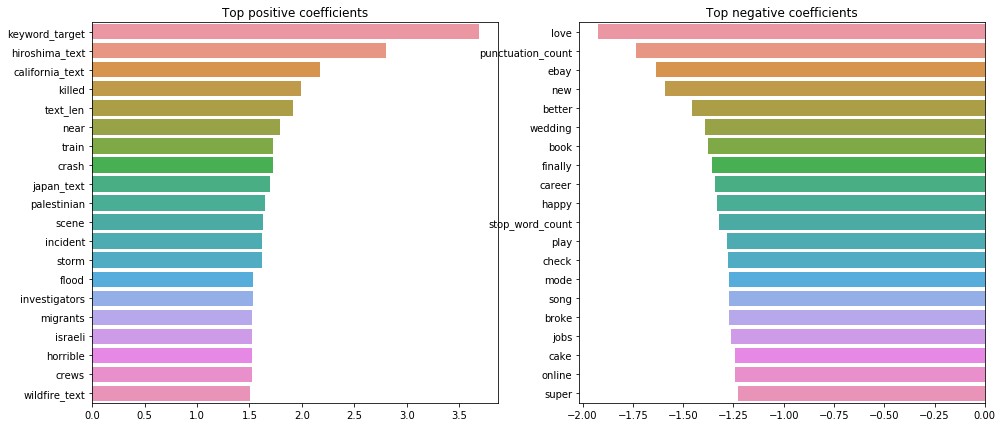

In [64]:
# Top features with fine-tuned model
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train2.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train2.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

Next, we inspect the tweets that predicted probability differs the most from target outcome

In [65]:
# Error analysis
y_hat = pipeline_grid.predict_proba(X_train2)[:,1]
checker = train.loc[:,['text','keyword','location','target']]
checker['pred_prob'] = y_hat
checker['error'] = np.abs(checker['target'] - checker['pred_prob'])

# Top 50 mispredicted tweets
error50 = checker.sort_values('error', ascending=False).head(50)
error50 = error50.rename_axis('id').reset_index()
error50.target.value_counts()

1    46
0     4
Name: target, dtype: int64

Among the top 50 mispredicted tweets, only 4 are false positive

In [66]:
pd.options.display.max_colwidth = 200

error50.loc[0:10,['text','target','pred_prob']]

,text,target,pred_prob
0,all that panicking made me tired ;__; i want to sleep in my bed,1,0.036239
1,@OllyMursAus I do feel sorry for him! He is not a piece of meat! He is a nice guy... People don't need to rush him and screams in his face!,1,0.041651
2,@BenKin97 @Mili_5499 remember when u were up like 4-0 and blew it in one game? U probs don't because it was before the kings won the cup,1,0.044537
3,The Opposite of Love is Fear HereÛªs Why\nhttp://t.co/r5bXZzhXkm,1,0.049254
4,I liked a @YouTube video from @itsjustinstuart http://t.co/oDV3RqS8JU GUN RANGE MAYHEM!,1,0.050002
5,Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,1,0.052881
6,Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F,1,0.055082
7,I can't drown my demons they know how to swim,1,0.056195
8,Just came back from camping and returned with a new song which gets recorded tomorrow. Can't wait! #Desolation #TheConspiracyTheory #NewEP,1,0.056478
9,How long O Lord (Study 3)\n The sixth seal opens the events of Revelation 12. The political upheaval in the Roman... http://t.co/GW0CXoOJyV,1,0.058416


### Q. 변수가 Categorical, Continuous인지 확인하는 코드?

To Do :
- 추가적으로 다른 분류 모델도 사용해볼 것!

# Reference
- https://www.kaggle.com/aaroha33/disaster-tweets-evaluation-with-nlp